In [1]:
# ! pip install git+https://github.com/openai/CLIP.git
! pip install git+https://github.com/pmj951030/koclip_MJei.git

  Cloning https://github.com/pmj951030/koclip_MJei.git to c:\users\asus rog g15dh\appdata\local\temp\pip-req-build-5jqcf4rk
  Resolved https://github.com/pmj951030/koclip_MJei.git to commit bd3ff75a21adc3bf5535ceb709cbd52850d4b1e7
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for clip: filename=clip-1.134-py3-none-any.whl size=1373459 sha256=c11f52179da2e154a0c9d05f858bc8fe4a345ecef1089e29f36cf6ecb82a3d38
  Stored in directory: C:\Users\ASUS ROG G15DH\AppData\Local\Temp\pip-ephem-wheel-cache-uvdzgw74\wheels\0b\1d\01\a5ef5d3cb48edf6c8731b9f0802417a34faedb87d4f0824ba3
Successfully built clip
  Attempting uninstall: clip
    Found existing installation: clip 1.133
    Uninstalling clip-1.133:
      Successfully uninstalled clip-1.133


  Running command git clone --filter=blob:none --quiet https://github.com/pmj951030/koclip_MJei.git 'C:\Users\ASUS ROG G15DH\AppData\Local\Temp\pip-req-build-5jqcf4rk'


In [2]:
import json
import pandas as pd
import torch
import clip
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import re
import pandas as pd
from tqdm.notebook import tqdm
from glob import glob
import torch.nn as nn
import torch.optim as optim
import warnings ; warnings.filterwarnings('ignore')

In [3]:
## 파일 불러오기
with open('D:/coco_data/MSCOCO_train_val_Korean.json') as f:
    json_data = json.load(f)
json_data=pd.DataFrame(json_data)
json_data['file_path']=json_data['file_path'].apply(lambda x : 'D:/coco_data/'+x)

In [4]:
def remove_text_len_100(input_list_text):
    """
    텍스트 길이(띄어쓰기포함)100글자 이상인것은 caption_ko에서 제거함 ,
    데이터 보았을때 kobert토큰 개수 77이상일때 최소 글자길이 103이었기 때문
    """
    list_result=[text for text in input_list_text if len(text)<=100 and text!='']
    
    return list_result

In [5]:
json_data['caption_ko']=json_data['caption_ko'].apply(lambda x : remove_text_len_100(x))

In [6]:
json_train_data=json_data[json_data['file_path'].str.contains('train')] ## train만 추출
json_train_data['caption_ko']=json_train_data['caption_ko'].apply(lambda x : '!@#'.join(x)) ## 한문장으로 만들음 -> 분리시키려고

In [7]:
json_train_data=json_train_data.head(100)

In [8]:
## 리스트 문장 연결시킨거 다시 구분자로 분리
train_data=json_train_data['caption_ko'].str.split('!@#') ## 콤마단위로 분리
train_data=train_data.apply(lambda x : pd.Series(x)) ## 시리즈로 변경
train_data = train_data.stack().reset_index(level=1, drop=True).to_frame('caption_ko') ## 분리된 데이터 생성
json_train_data.drop('caption_ko',axis=1,inplace=True) ## 중복되는 열 제거
train_data = json_train_data.merge(train_data, left_index=True, right_index=True, how='left') ## 연결
train_data.reset_index(drop=True,inplace=True)

In [9]:
# train_data=train_data.sample(frac=1).reset_index(drop=True)
# train_data=train_data.head(8000)

In [10]:
train_data['caption_ko']=train_data['caption_ko'].apply(lambda x : re.sub('(?:\.)','',x).strip())

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.

In [12]:
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training

In [13]:
class image_title_dataset(Dataset):
    def __init__(self, list_image_path,list_txt):

        self.image_path = list_image_path
        self.title  = clip.tokenize(list_txt) #you can tokenize everything at once in here(slow at the beginning), or tokenize it in the training loop.
        self.list_txt=list_txt ## 이거안하면 밑에 len에서 에러남
    
    def __len__(self):
        return len(self.list_txt) ## self.list_txt=list_txt 안하면에러남
#         return 35700#len(self.list_txt)
    


    def __getitem__(self, idx):
        image = preprocess(Image.open(self.image_path[idx])) # Image from PIL module
        title = self.title[idx]
        return image,title

In [14]:
BATCH_SIZE=1#25
EPOCH=5

In [15]:
list_image_path=list(train_data['file_path'].values)
list_txt = list(train_data['caption_ko'].values)

dataset = image_title_dataset(list_image_path,list_txt)
train_dataloader = DataLoader(dataset,batch_size = BATCH_SIZE)

In [16]:
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

In [17]:
if device == "cpu":
    model.float()
else :
    clip.model.convert_weights(model) # Actually this line is unnecessary since clip by default already on float16

In [18]:
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
# lr=5e-5   eps=1e-6
# optimizer = optim.Adam(model.parameters(), lr=1e-3,betas=(0.9,0.98),eps=1e-3,weight_decay=0.2) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset
optimizer = optim.Adam(model.parameters(), lr=1e-2) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset

In [20]:
texts

tensor([[   2, 3007, 6900, 5051, 6730,  517, 5660,  517, 7589, 7165,  517, 7095,
         7148, 3862,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0]], device='cuda:0', dtype=torch.int32)

In [19]:
for epoch in tqdm(range(EPOCH)):
    for batch in train_dataloader :
        optimizer.zero_grad()

        images,texts = batch 
    
        images= images.to(device)
        texts = texts.to(device)
    
        logits_per_image, logits_per_text = model(images, texts)

        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)

        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else : 
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

  0%|          | 0/5 [00:00<?, ?it/s]

RuntimeError: Input, output and indices must be on the current device

In [30]:
for epoch in tqdm(range(EPOCH)):
    for batch in train_dataloader :
        optimizer.zero_grad()

        images,texts = batch 
    
        images= images.to(device)
        texts = texts.to(device)
    
        logits_per_image, logits_per_text = model(images, texts)

        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)

        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else : 
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

  0%|          | 0/5 [00:00<?, ?it/s]

TypeError: only integer tensors of a single element can be converted to an index

In [17]:
try:
    for epoch in tqdm(range(EPOCH)):
        try:
            for batch in tqdm(train_dataloader) :
                try:
                    optimizer.zero_grad()

                    images,texts = batch
                    images= images.to(device)
                    texts = texts.to(device)

                    logits_per_image, logits_per_text = model(images, texts)

                    ground_truth = torch.arange(len(images),dtype=torch.long,device=device)

                    total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
                    total_loss.backward()
                    if device == "cpu":
                        optimizer.step()
                    else : 
                        convert_models_to_fp32(model)
                        optimizer.step()
                        clip.model.convert_weights(model)
                except Exception as e:
                    print('1 : ',e)
                    pass
        except Exception as e:
            print('2 : ',e)
            pass
                
except Exception as e:
    print('3 : ',e)
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss,
            }, f"D:/coco_data/model_10.pt") #just change to your preferred folder/filename
    
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
        }, f"D:/coco_data/model_10.pt") 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1 :  name 'optimizer' is not defined
1 :  name 'optimizer' is not defined
1 :  name 'optimizer' is not defined
1 :  name 'optimizer' is not defined
1 :  name 'optimizer' is not defined
1 :  name 'optimizer' is not defined
1 :  name 'optimizer' is not defined
1 :  name 'optimizer' is not defined
1 :  name 'optimizer' is not defined
1 :  name 'optimizer' is not defined
1 :  name 'optimizer' is not defined
1 :  name 'optimizer' is not defined
1 :  name 'optimizer' is not defined
1 :  name 'optimizer' is not defined


KeyboardInterrupt: 

# 모델 테스트 해보기

In [21]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch
%matplotlib inline

In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.

# 이거 아래꺼 하면 오래걸림, 아마 체크포인트 제거하든가 해야할듯

In [5]:
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
checkpoint = torch.load("D:/coco_data/model_10.pt")


model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [22]:
from matplotlib import font_manager,rc
font_name=font_manager.FontProperties(fname="C:/Windows/Fonts/HYDNKB.TTF").get_name()
rc('font',family=font_name)

In [23]:
# json_valid_data=json_data[json_data['file_path'].str.contains('train')] ## train만 추출
# json_valid_data=json_valid_data.head(10)
# json_valid_data['caption_ko']=json_valid_data['caption_ko'].apply(lambda x : x[0])


json_valid_data=json_data[json_data['file_path'].str.contains('val')] ## train만 추출
json_valid_data=json_valid_data.head(8)
json_valid_data['caption_ko']=json_valid_data['caption_ko'].apply(lambda x : x[0])

  0%|          | 0/8 [00:00<?, ?it/s]

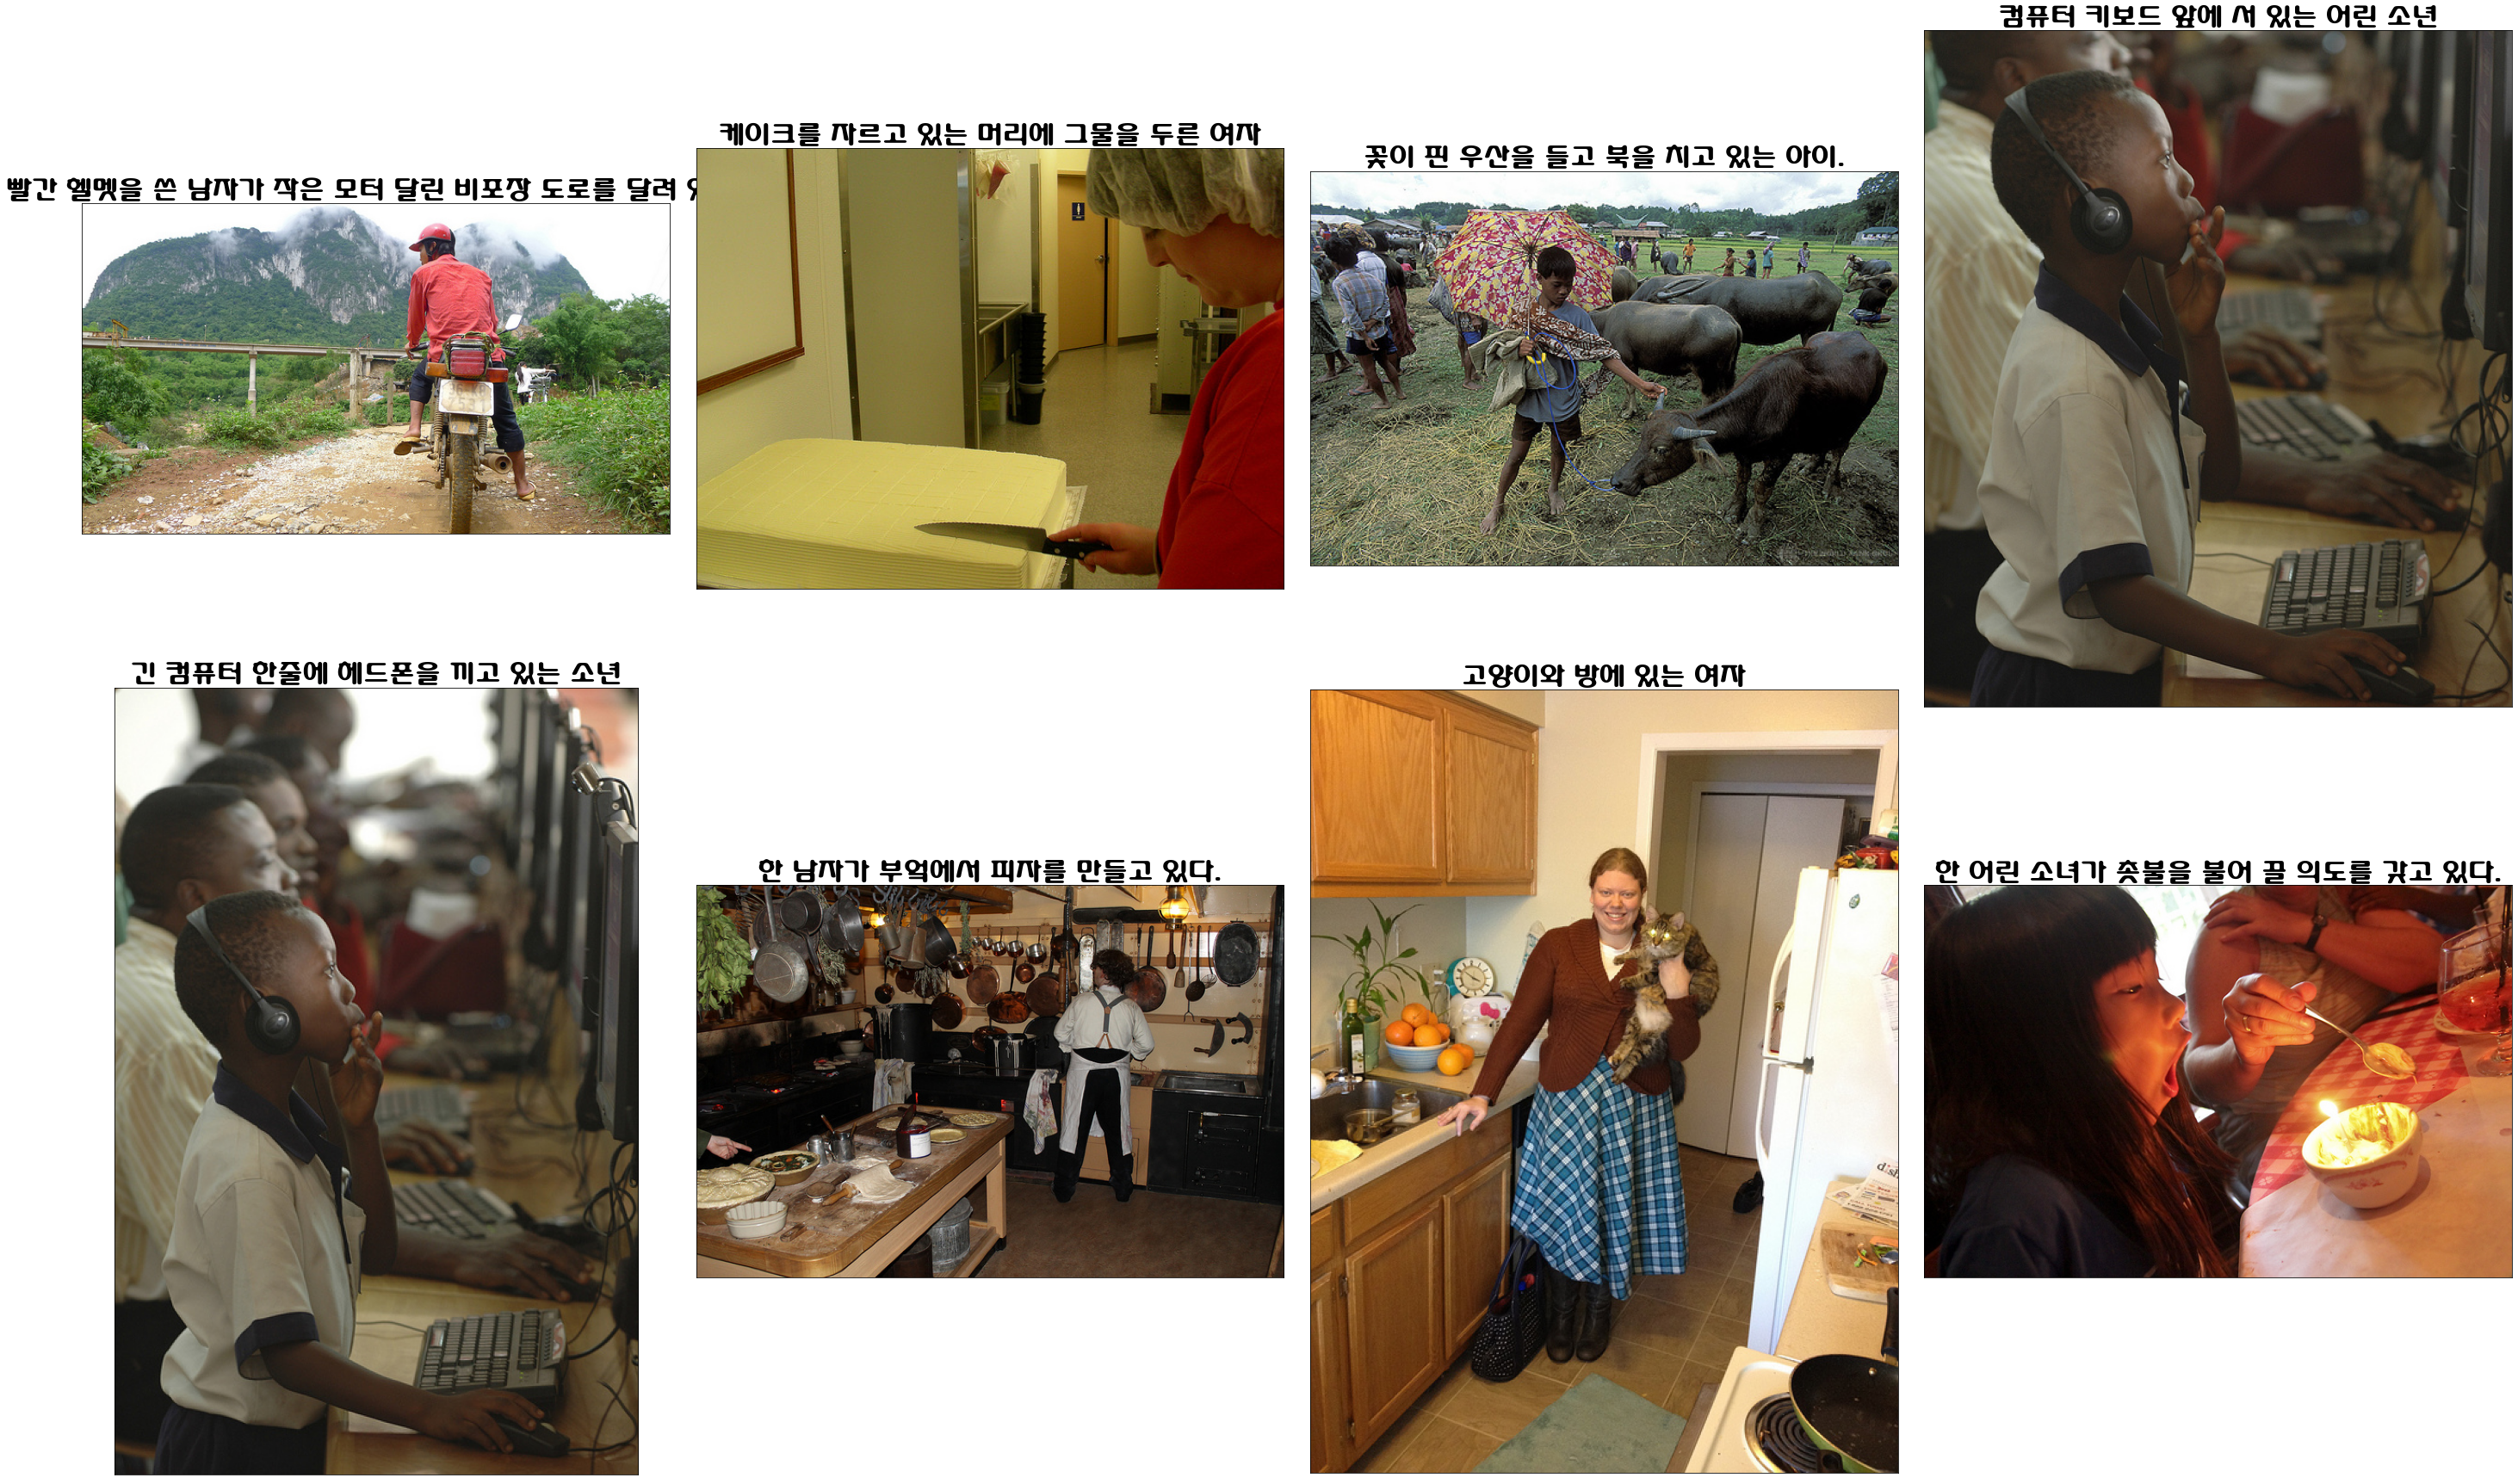

In [24]:
original_images = []
images = []
texts = []
plt.figure(figsize=(40, 25))
plt.rc('font', size=25) # 글자크기

for i in tqdm(range(len(json_valid_data))): 

    image = Image.open(json_valid_data['file_path'].iloc[i]).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(json_valid_data['caption_ko'].iloc[i])
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(json_valid_data['caption_ko'].iloc[i])

plt.tight_layout()


In [32]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize([desc for desc in texts]).cuda()

In [265]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [43]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

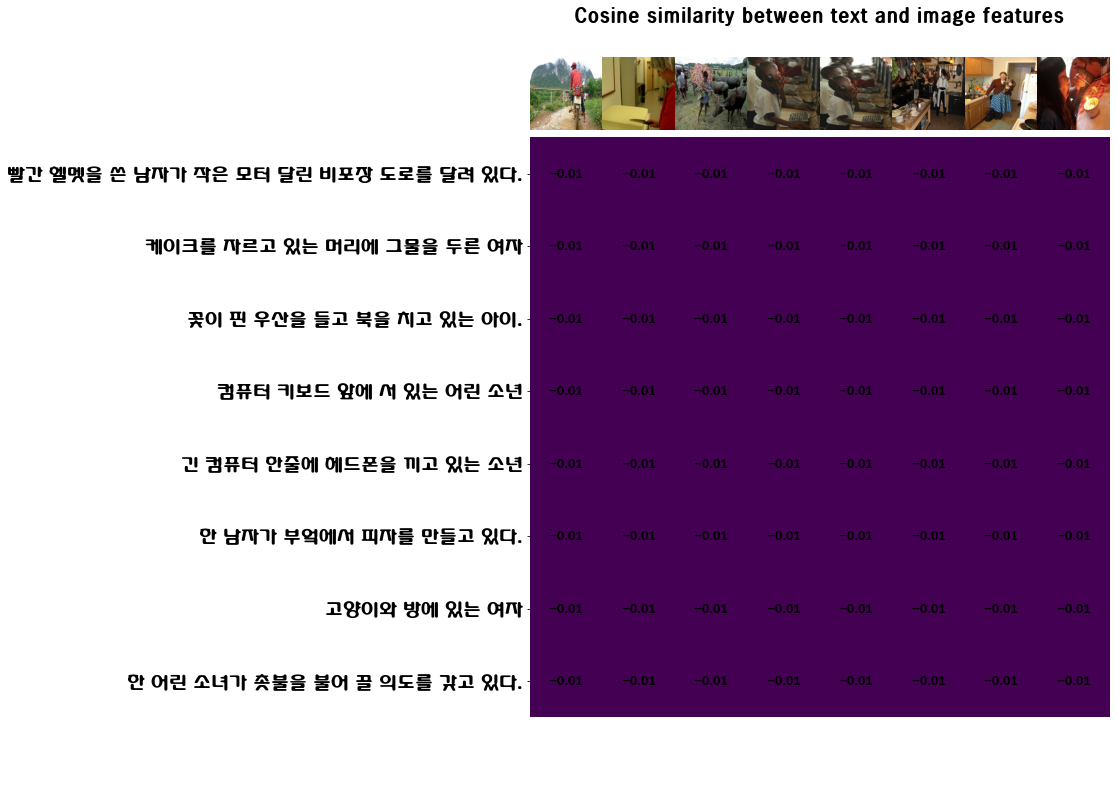

In [28]:
count = len(json_valid_data)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

In [21]:
text_descriptions=[i for i in train_data['caption_ko']]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [22]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

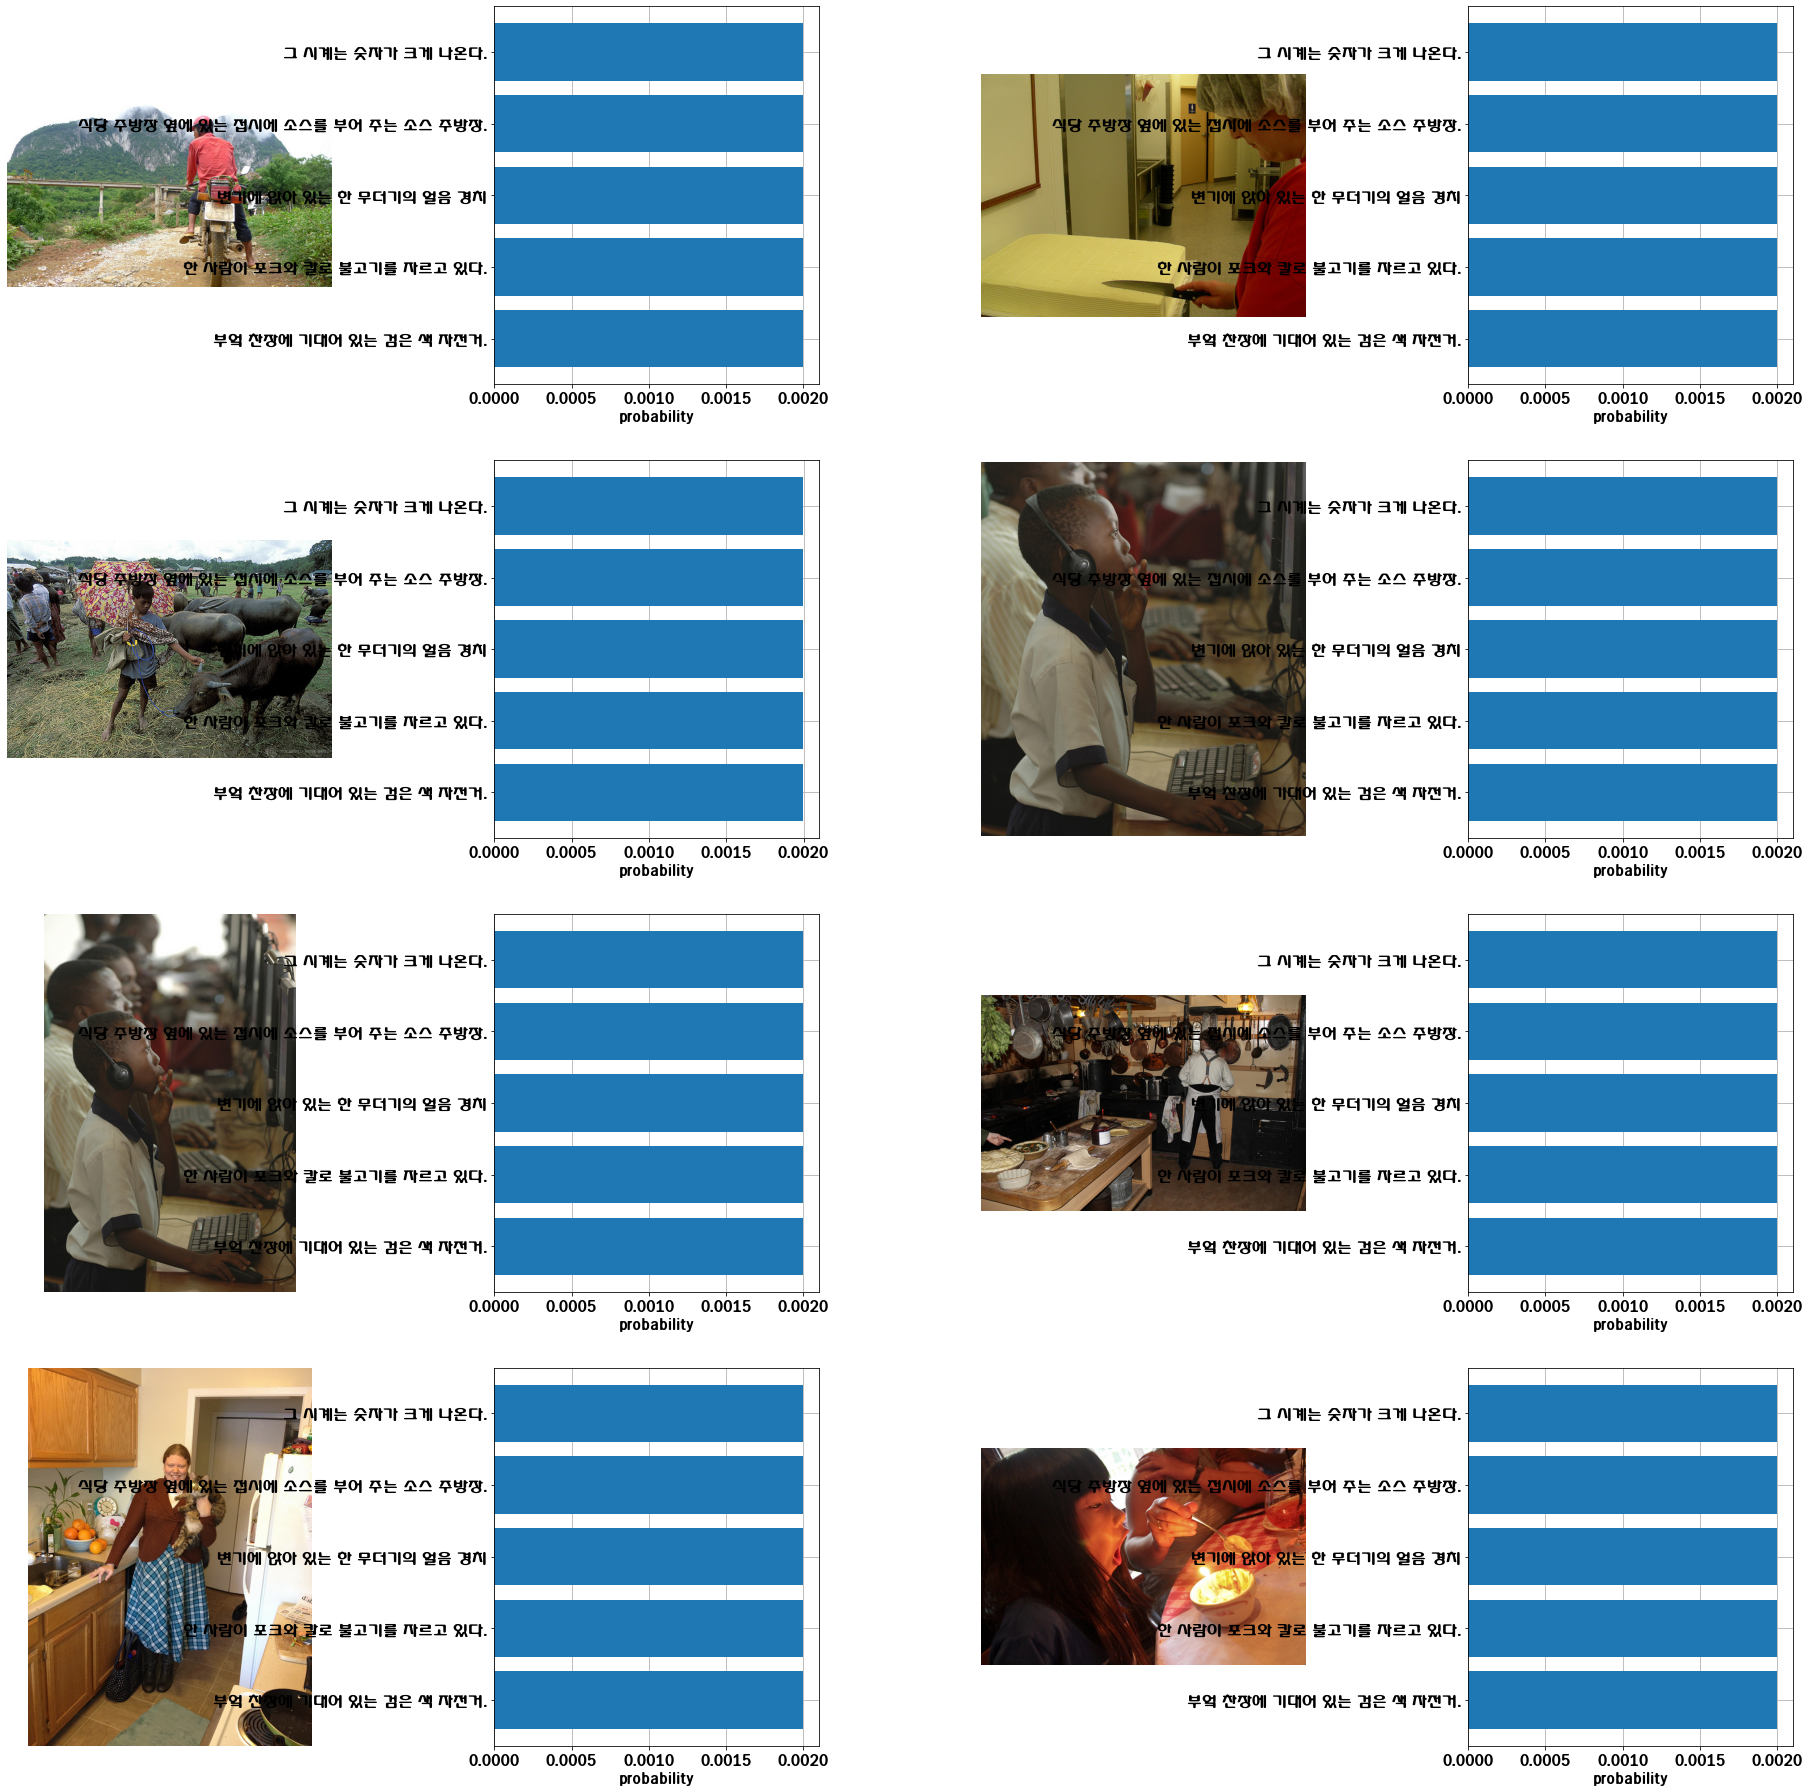

In [23]:
plt.figure(figsize=(32, 32))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [text_descriptions[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

# 작업장

In [35]:
import itertools
a=list(itertools.chain(*a))

In [36]:
data_a=pd.DataFrame(a,columns=['test'])

In [38]:
from KoBertTokenizer_MJ import KoBertTokenizer

In [39]:
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

In [42]:
def input_text(text):
    result=tokenizer.tokenize(text)
    result=len(tokenizer.convert_tokens_to_ids(result))
    
    return result

In [43]:
list_result=[]
for i in tqdm(data_a['test']):
    list_result.append(input_text(i))

  0%|          | 0/616767 [00:00<?, ?it/s]

In [ ]:
data_a['길이']=list_result

In [53]:
data_a['그냥 텍스트 길이']=data_a['test'].apply(lambda x : len(x))

In [65]:
data_a[data_a['test']=='']

test  길이  그냥 텍스트 길이
251209        0          0

In [63]:
data_a.sort_values('길이',ascending=False)

test  길이  그냥 텍스트 길이
606054  로고가 새겨진 가운데 있는 레스토랑 테이블 위와 유리 아래의 광고, 종이 냅킨으로 ...  81        118
305034  나무 뼈대가 있는 타원형 거울은 하얀 방, 작고 밝은 창문, 잡동사니, 옷 걸이용 ...  80        135
560024  방은 목재 바닥, 큰 창문, 식물, 파란 벽, 가죽 소파 그리고 병 수집, 책, 그...  80        122
56759   접시 위에 50개의 자동차 모델이 있고, 위에 핫도그 롤과 프라이, 냅킨 디스펜서,...  78        122
164163  조리장 및 학습장, 타일을 깐 조리대, 오븐 및 오버 헤드 마이크로파, 향신료 선반...  78        116
...                                                   ...  ..        ...
169317                                                화장실   1          3
458952                                                화장실   1          3
213366                                                화장실   1          3
525807                                                화장실   1          3
251209                                                      0          0

[616767 rows x 3 columns]

In [57]:
data_a.sort_values('그냥 텍스트 길이',ascending=False).head(50)

test  길이  그냥 텍스트 길이
576877  화려하게 칠해져 있는 이 두줄에는 열악하게 포장된 도로가 한줄로 늘어서 있어 50개...  72        136
305034  나무 뼈대가 있는 타원형 거울은 하얀 방, 작고 밝은 창문, 잡동사니, 옷 걸이용 ...  80        135
179245  뚜껑을 덮고 있지 않은 거친 목재 테이블은 옆에 식기가 놓여 있고, 어울리는 네모난...  70        130
10833   도로 사진에는 무선 더듬이와 작은 부분의 앞 유리, 갈색 산 비탈, 옆의 사라지는 ...  62        124
560024  방은 목재 바닥, 큰 창문, 식물, 파란 벽, 가죽 소파 그리고 병 수집, 책, 그...  80        122
56759   접시 위에 50개의 자동차 모델이 있고, 위에 핫도그 롤과 프라이, 냅킨 디스펜서,...  78        122
152569  두개의 레스토랑 부스가 보이는데, 한쪽은 웃고 있는 여자고, 다른 한쪽은 음료수를 ...  67        120
54753   전면이 흐릿한 것은 음식을 담을 수 있는 물건들이 있는 카운터 위를 암시하는 반면,...  64        120
466174  가장 먼 곳에서 가장 가까운 곳까지, 영국의 경치는 구름, 텐트, 사람들이 걷고, ...  63        119
606054  로고가 새겨진 가운데 있는 레스토랑 테이블 위와 유리 아래의 광고, 종이 냅킨으로 ...  81        118
29511   네개의 네모난 나무 기둥 위에 공이 있고, 그 위에 줄무늬가 있는 크리스마스 양말이...  70        117
122930  어두운 방의 간접적인 조명이 남은 음식으로 덮여 있는 테이블을 가로질러 작동하기 때...  70        116
164163  조리장 및 학습장, 타일을 깐 조리대, 오븐 및 오버 헤드 마이크로파, 향신료 선반...  78        116
526247  앞 유리를 통해 볼 수 있는 것은, 먼 거리의 보도이며, 눈, 전신주, 소매 초소 ...  62        115
481514  분홍색의 열린 우산을 들고 밝은 색의 꽃 장식이 달린 수영복을 입은 채, 한 여자가...  64        115
410012  와이드 스크린 텔레비전 화면과 컴퓨터 화면이 나란히 있는 긴 테이블이 있는 방, 프...  71        114
273987  저작권이 있는 식품 사이트의 이미지는 벽돌 벽과 한쪽 끝에 강철 카운터가 있는 고급...  58        114
137396  크고 불규칙한 형태의 방으로, 틈새와 출입구에 지어지고, 침실과 식사 공간의 일부를...  69        114
275320  이 사진은 오토바이 폐쇠에 달린 계기판을 보여 주고 있습니다. 그리고 이를 지나 두...  63        113
127971  거울 중 하나를 통해 보면 살롱에는 짙은 목재 테두리와 천장 팬, 검은 의자, 사진...  63        113
344995  리모컨의 가운데 부분을 닫습니다. 위에 라벨이 있는 검은 색이나 흰색 또는 화살표 ...  74        113
616058  목재 바닥, 중간, 벽난로 그리고 벽난로 스크린의 고급스러운 바닥 깔개, 벽에 액자...  71        113
419898  앉아 있는 한 무리의 사람들은 약간의 예외를 제외하고 주로 양복을 입는 백인 남성들...  61        113
310215  바깥에, 많은 자상한 사람들이 있는데, 대부분이 검은 상의를 입은 채로, 직사각형의...  63        111
141651  포크가 있는 두개의 타원형 접시의 측면도 옆에 치킨 샐러드 샌드위치와 장미 빛의 새...  73        111
125456  가장자리에 있는 사람들을 보여 주는 큰 네모난 콘크리트 벽에는 먼지 구름이 끼어 있...  58        111
457780  구형 컴퓨터 부품:두개의 디스크 드라이브 박스, 키보드 유닛, 그리고 사과 로고 중...  63        110
218054  바나나와 다른 물건들 그리고 검은 대리석 위에 조리대, 싱크대, 그리고 다양한 부엌...  67        110
376758  흐릿한 사진 한장은 장난감 돼지가 그려진 부엌 의자를 보여 주고 있는데, 앞으로는 ...  62        110
95187   야구장 유니폼을 입은 사람과 야구장에 있는 사람의 머리와 어깨 뒤에서 보면, 마운드...  50        110
181839  동물성 얼룩 무늬 우산을 들고 있는 사람의 정면도. 이렇게 하면 팔이 "세일" 하는...  56        110
86054   오래 된 책상 위에 놓여 있는 한쌍의 부트를 보여 주는 공중 사진에는 책상 위에 놓...  55        110
530836  나무 사이로 멀리 떨어져 있는, 아름답게 정비된 공원 같은 경사면이 있는 많은 사람...  58        109
365984  대각선 뒤쪽 뷰에는 팔걸이와 바퀴가 있는 패딩 처리된 책상 의자가 있고, 필기 도구...  67        109
500697  대리석 벤치에 앉아 있는 두 여성 중 한명은 카메라를 보고수박 쐐기를 잡아 먹으며 ...  62        109
528523  방의 작은 부분은 창문 틀의 한 부분을 보여 주고 그 아래로 의자 두개가 있는 테이...  66        109
361848  검은 색과 흰색의 둥근 색의 사진은 구름 낀 하늘과 나무들이 보이는 콘크리트 테두리...  65        109
108756  최소로 가구가 배치된 방은 블라인드와 커튼이 없는 작은 창문 쌍, 무거운 컵 이불이...  59        108
224373  거리의 전망은 배경에 버스를 포함하여 건물 입구와 교통 상황을 보여 주며, 앞쪽에 ...  63        108
227834  책 위에 놓여 있는 휴대폰은, 눈에 잘 띄지 않는 많은 탁자들을 덮고 있는, 부주의...  62        108
603950  빨간 색과 흰색으로 이루어진 콜라주로, 여성의 머리에 있는 반다나, 부엌 식탁 커버...  76        108
314726  더그 아웃에서 보이는 세 사람이 울타리로 떨어져 있다.  한 어린 소년이 타석에 들...  55        108
84160   뒤에서는 나무 자루 울타리가 가로등으로 거리 수준을 구분한다.  건물들과 서 있는 ...  55        108
251291  포크와 음식 조각이 몇개 있는 접시가 있는 카운터 위와 포크 근처의 접시 위에 팔을...  65        107
515188  팔을 뻗은 채로 트위스트 위치에 서 있는 여자와 그녀의 근처의 공기 중에 있는 프리...  65        107
360244  모텔 종류의 방에는 소파, 더블 침대, 봉제 의자, 책상 의자, 책상, 옷장 및 텔...  67        107
379083  양동이가 있는 진흙 지대는 나무로 된 난간을 향하고, 그 앞에는 미소 짓는 사람들이...  64        107
318329  첫번째 그림에서 한 소년이 스케이트 보드를 뒤집고 있고, 두번째 그림은 스케이트 보...  58        107
365605  아시아 양탄자를 깔아 놓고 나무 바닥에 다리를 꼬고 앉아 있는 한 남자가 레이스, ...  62        107
467101  눈 덮인 눈 덮인 지역에서는 서로 밀치는 스키어 두명이 한쪽 다리만 보이고 다른 한...  56        107